In [1]:
import os
from transformers import pipeline
import torch
from dotenv import load_dotenv
from PIL import Image
import requests
from IPython.display import display

In [2]:
load_dotenv()

MODEL = os.getenv("TRANSFORMERS_MODEL")
IMG_PATH = 'data/img/IMG_1442.jpg'

In [40]:
from transformers import Swin2SRForImageSuperResolution

model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64")

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipeline(task="image-to-image", model=MODEL, device=device)

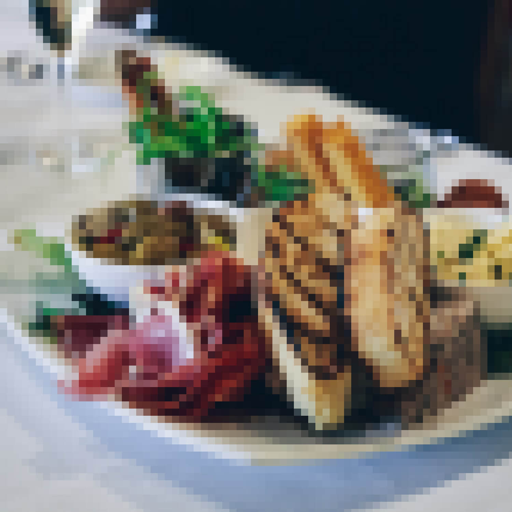

In [42]:
url = "data/pixl-Why-We-Love-Low-Resolution-Images.jpg"
image = Image.open(url)

# turn into 1:1 aspect ratio
image = image.resize((512, 512))

display(image)

# trim

In [43]:
from transformers import Swin2SRImageProcessor 

processor = Swin2SRImageProcessor()

In [44]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 520, 520])


In [45]:

import torch

with torch.no_grad():
  outputs = model(pixel_values)

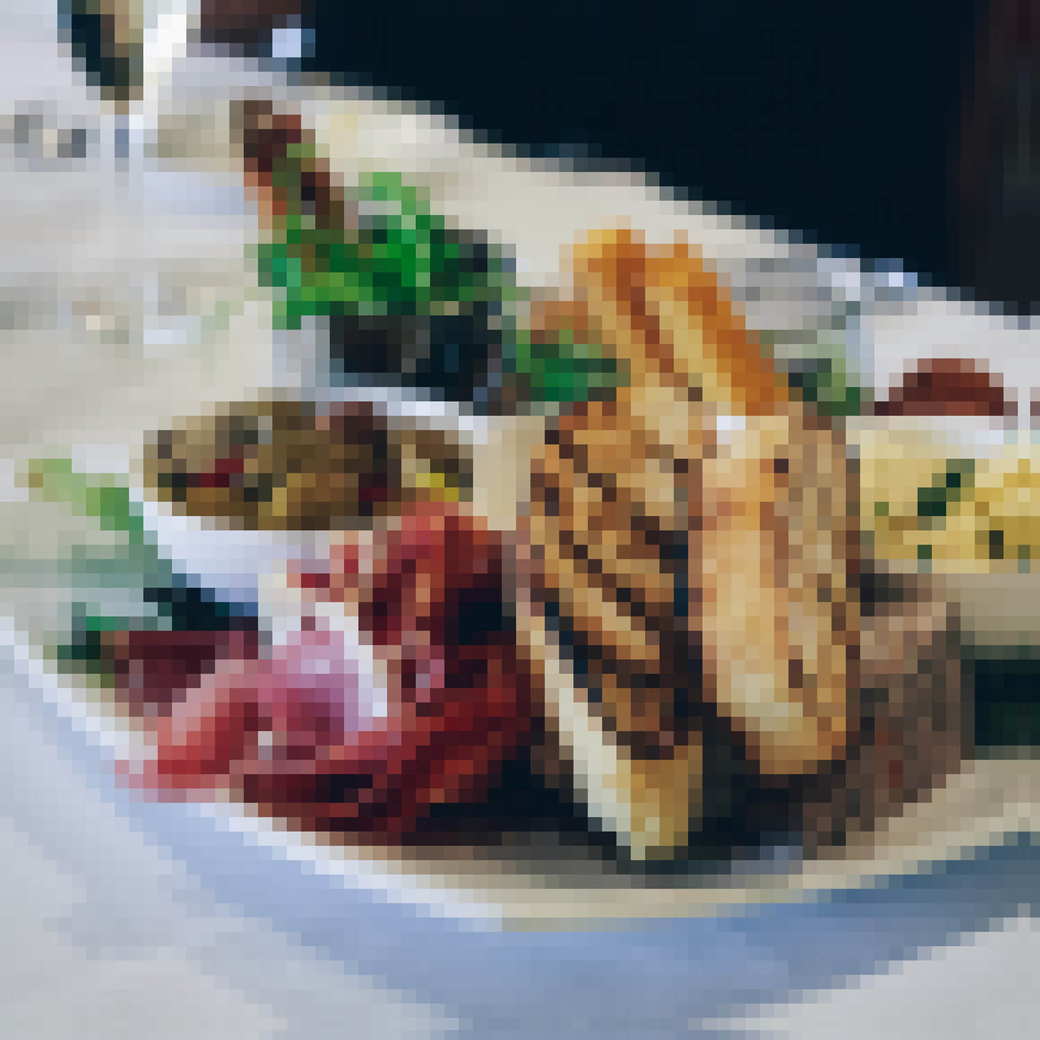

In [47]:
import numpy as np

output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)
output = (output * 255.0).round().astype(np.uint8)
i = Image.fromarray(output)
display(i)

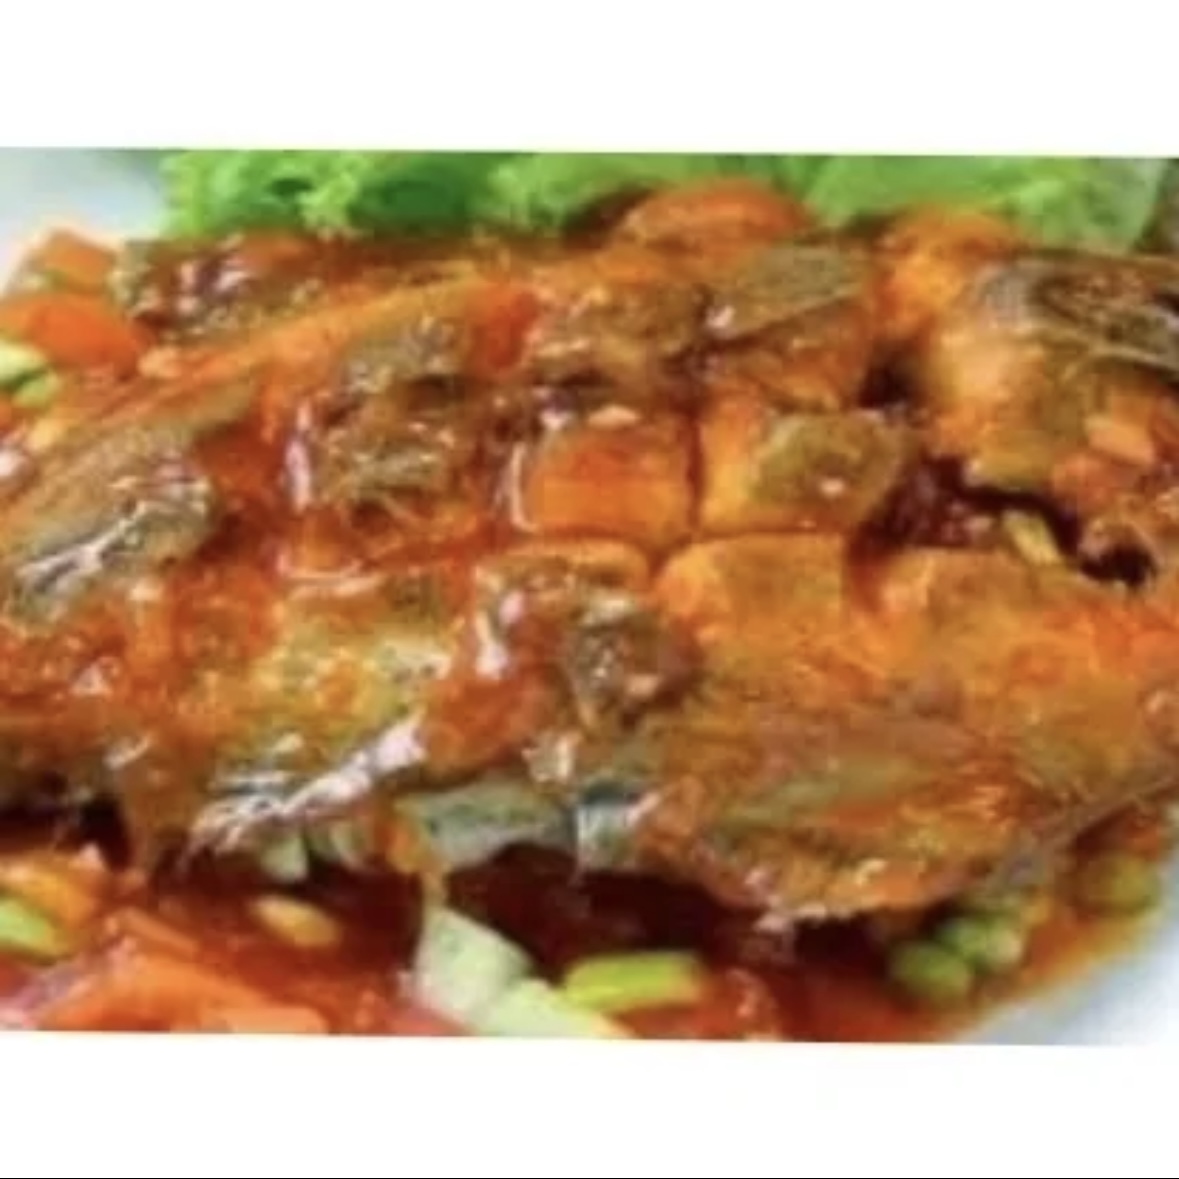

blurriness: 280.4640288357048
sharpness: 0.5952881965352101
resolution: 1179 1179
Quality check results for data/img/IMG_1442.jpg:
has_border: True
is_blurry: True
is_low_sharpness: True
is_low_resolution: False
is_square_image: True


In [88]:
image_path = 'data/img/IMG_1442.jpg'
display(Image.open(image_path))
checker = ImageQualityChecker(image_path)
results = checker.check_quality()

print(f"Quality check results for {image_path}:")
for key, value in results.items():
    print(f"{key}: {value}")

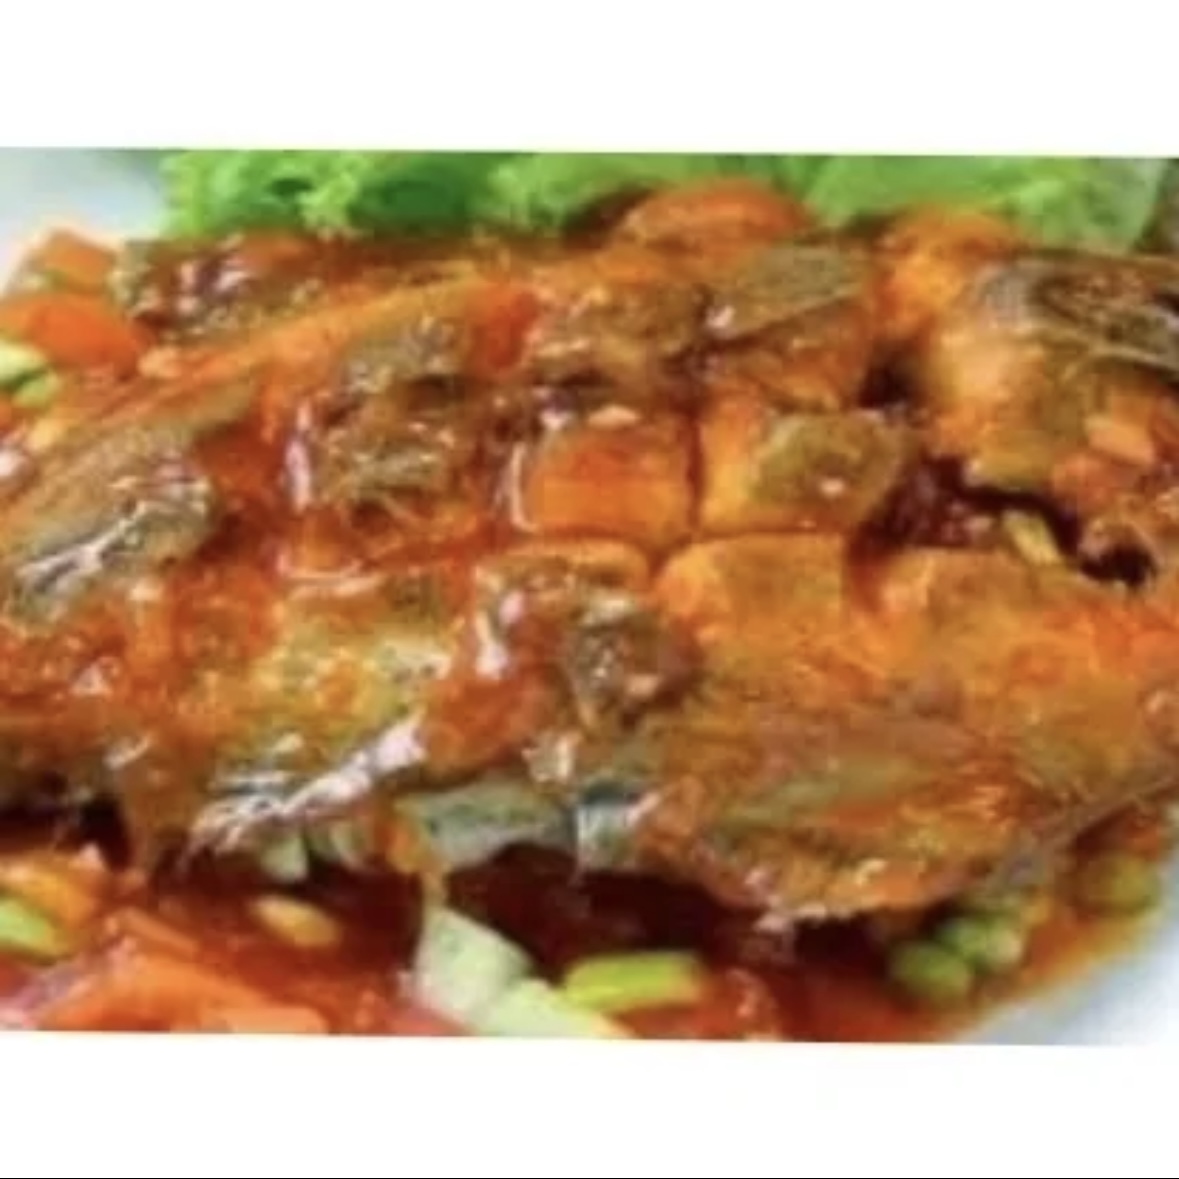

In [50]:
# show image in jupyter

img = Image.open(IMG_PATH)
display(img)


In [51]:
from transformers import Swin2SRImageProcessor 

processor = Swin2SRImageProcessor()

In [52]:
pixel_values = processor(img, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1184, 1184])


In [54]:
# import torch

# with torch.no_grad():
#   outputs = model(pixel_values)

In [13]:
# resize image to lower resolution 256x256 without pipeline

img = img.resize((256, 256))

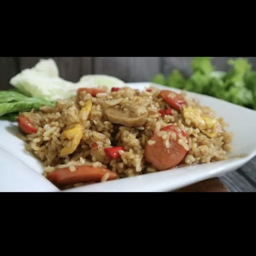

In [14]:
display(img)

In [15]:
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def process_image(image_path):
  img = Image.open(image_path)
  if img.size[0] != img.size[1]:
    size = min(img.size)
    img = img.crop((0, 0, size, size))
  else:
    print("Rejected")
    img = trim(img)
  return img

In [16]:
img2 = process_image(IMG_PATH)

Rejected


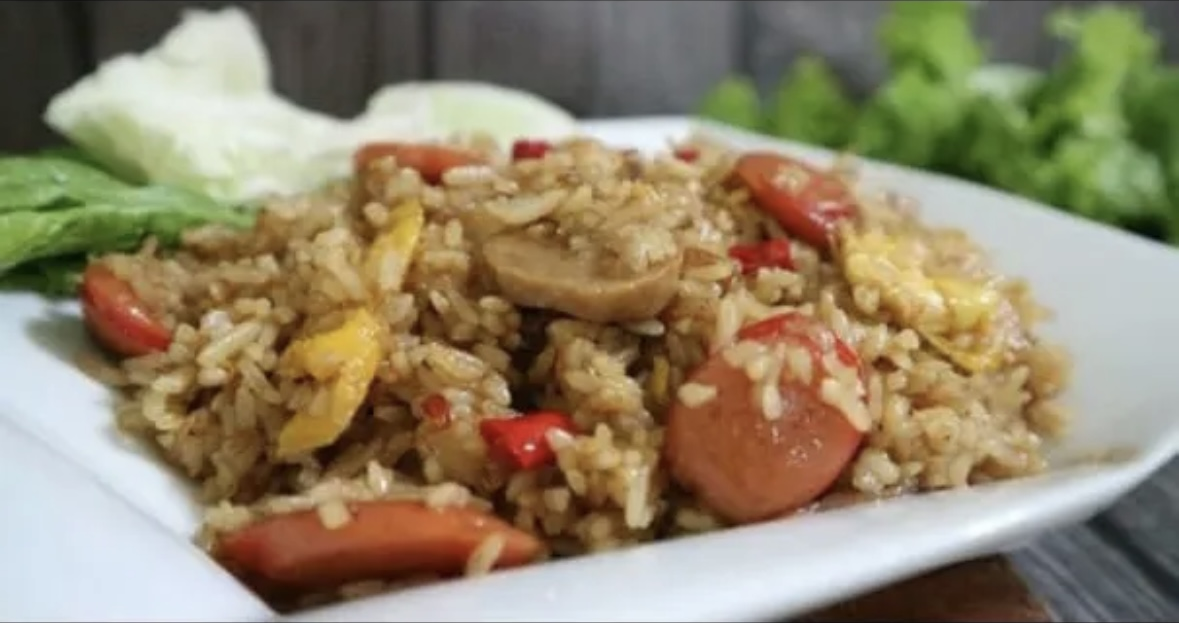

In [17]:
display(img2)

In [18]:
# detect low resolution images

def is_low_res(image_path):
    img = Image.open(image_path)
    if img.size[0] < 256 or img.size[1] < 256:
        return True
    return False

In [20]:
is_low_res('data/img/IMG_1442.jpg')

False

In [49]:
from cleanvision import Imagelab

In [50]:
# image lab in folder data/img

lab = Imagelab('data/img')

Reading images from /Users/cindybtari/Documents/cmpwg_cohere/cmpwg/cmpwg_hackjakarta/data/img


In [51]:
# find issue

lab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Issue checks completed. 2 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | odd_size         |            2 |
|  1 | dark             |            0 |
|  2 | light            |            0 |
|  3 | odd_aspect_ratio |            0 |
|  4 | low_information  |            0 |
|  5 | blurry           |            0 |
|  6 | grayscale        |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

--------------------- odd_size images ----------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



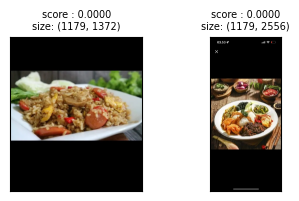

In [53]:
lab.report()

In [35]:
imagelab.report()

Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            0 |
|  1 | light            |            0 |
|  2 | odd_aspect_ratio |            0 |
|  3 | low_information  |            0 |
|  4 | blurry           |            0 |
|  5 | grayscale        |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 



In [44]:
from super_image import MsrnModel, ImageLoader
from PIL import Image
import requests

url = 'https://paperswithcode.com/media/datasets/Set5-0000002728-07a9793f_zA3bDjj.jpg'
image = Image.open(requests.get(url, stream=True).raw)

model = MsrnModel.from_pretrained('eugenesiow/msrn-bam', scale=2)      # scale 2, 3 and 4 models available
inputs = ImageLoader.load_image(image)
preds = model(inputs)

ImageLoader.save_image(preds, './scaled_2x.png')                        # save the output 2x scaled image to `./scaled_2x.png`
ImageLoader.save_compare(inputs, preds, './scaled_2x_compare.png')      # save an output comparing the super-image with a bicubic scaling

/opt/homebrew/Caskroom/miniforge/base/envs/cohere_env/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/cohere_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:680: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cohere_env/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'url_to_filename' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` to benefit from the new cache layout.
  warnings.warn(warning_message, FutureWarning)


https://huggingface.co/eugenesiow/msrn-bam/resolve/main/pytorch_model_2x.pt


/opt/homebrew/Caskroom/miniforge/base/envs/cohere_env/lib/python3.12/site-packages/super_image/modeling_utils.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dic